In [ ]:
pip install pandas pyarrow matplotlib scikit-learn torch torch-geometric pyarrow fastparquet

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
if torch.cuda.is_available():
    # Get current device
    device = torch.cuda.current_device()

    # Get allocated and reserved memory
    allocated_memory = torch.cuda.memory_allocated(device)
    reserved_memory = torch.cuda.memory_reserved(device)

    # Compute free memory
    free_memory = reserved_memory - allocated_memory

    # Convert bytes to human-readable format (MB)
    allocated_memory_MB = allocated_memory / 1024**2
    reserved_memory_MB = reserved_memory / 1024**2
    free_memory_MB = free_memory / 1024**2

    # Print the memory details
    print("Allocated memory: {:.2f} MB".format(allocated_memory_MB))
    print("Reserved memory: {:.2f} MB".format(reserved_memory_MB))
    print("Free memory: {:.2f} MB".format(free_memory_MB))
else:
    print("CUDA is not available.")


Allocated memory: 0.00 MB
Reserved memory: 0.00 MB
Free memory: 0.00 MB


In [2]:
############### GRAPH CONVOLUTIONAL NETWORK WITH DATA SPLITING  #############
'''
Data Preparation: Transform the data into a Data object, which is an inherent data type in PyG to represent a graph.
Model Definition: Define the GNN model.
Training and Evaluation: Train the GNN model and evaluate it.
'''

reviews_df = pd.read_parquet("dataset/yelp_dataset_ver2_small.parquet")

# 1. Data Preparation

# Create a list of user nodes and business nodes. We'll treat users as type 0 and businesses as type 1.
nodes = pd.concat([reviews_df['user_id'], reviews_df['business_id']]).unique()
node2idx = {node: i for i, node in enumerate(nodes)}

def prepare_data(df):
    edge_index = torch.tensor([[node2idx[src] for src in df['user_id']],
                               [node2idx[tgt] for tgt in df['business_id']]], dtype=torch.long)

    x = torch.tensor([1 if i < len(df['user_id'].unique()) else 0 for i in range(len(nodes))], dtype=torch.float).view(-1, 1)
    edge_attr = torch.tensor(df[['stars', 'review_useful', 'review_funny', 'review_cool']].values, dtype=torch.float)
    y = torch.tensor(df['stars'].values, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

# 3. Data Splitting
train_df, test_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

train_data = prepare_data(train_df).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
test_data = prepare_data(test_df).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


 10%|▉         | 19/200 [00:00<00:03, 46.08it/s]

Epoch: 10, Loss: 15.9579


 14%|█▍        | 29/200 [00:00<00:03, 46.49it/s]

Epoch: 20, Loss: 7.7956


 20%|█▉        | 39/200 [00:00<00:03, 46.67it/s]

Epoch: 30, Loss: 4.4161


 24%|██▍       | 49/200 [00:01<00:03, 47.70it/s]

Epoch: 40, Loss: 3.7017


 30%|██▉       | 59/200 [00:01<00:02, 47.30it/s]

Epoch: 50, Loss: 2.9212


 34%|███▍      | 69/200 [00:01<00:02, 46.81it/s]

Epoch: 60, Loss: 2.4652


 40%|███▉      | 79/200 [00:01<00:02, 45.94it/s]

Epoch: 70, Loss: 2.1099


 44%|████▍     | 89/200 [00:01<00:02, 46.41it/s]

Epoch: 80, Loss: 1.8437


 50%|████▉     | 99/200 [00:02<00:02, 46.88it/s]

Epoch: 90, Loss: 1.5647


 55%|█████▍    | 109/200 [00:02<00:01, 47.14it/s]

Epoch: 100, Loss: 1.3751


 60%|█████▉    | 119/200 [00:02<00:01, 47.26it/s]

Epoch: 110, Loss: 1.2002


 64%|██████▍   | 129/200 [00:02<00:01, 46.97it/s]

Epoch: 120, Loss: 1.0254


 70%|██████▉   | 139/200 [00:02<00:01, 46.87it/s]

Epoch: 130, Loss: 0.9000


 74%|███████▍  | 149/200 [00:03<00:01, 47.05it/s]

Epoch: 140, Loss: 0.7810


 77%|███████▋  | 154/200 [00:03<00:01, 44.93it/s]

Epoch: 150, Loss: 0.6821


 84%|████████▍ | 169/200 [00:03<00:00, 45.87it/s]

Epoch: 160, Loss: 0.6024


 90%|████████▉ | 179/200 [00:03<00:00, 46.58it/s]

Epoch: 170, Loss: 0.5227


 94%|█████████▍| 189/200 [00:04<00:00, 47.22it/s]

Epoch: 180, Loss: 0.4537


100%|█████████▉| 199/200 [00:04<00:00, 47.02it/s]

Epoch: 190, Loss: 0.4031


100%|██████████| 200/200 [00:04<00:00, 46.50it/s]


Epoch: 200, Loss: 0.3591


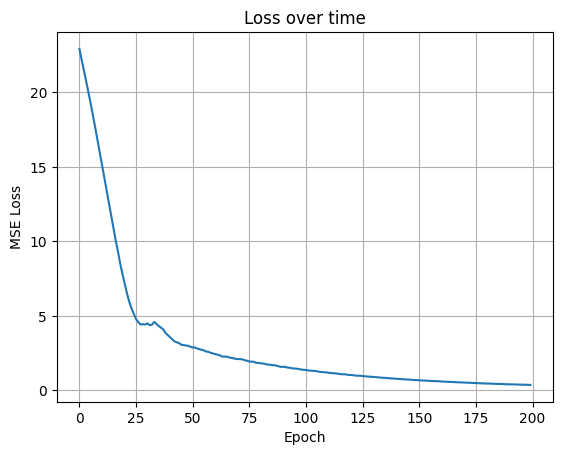

In [3]:
# 4. Model Definition
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)
        self.prediction_layer = torch.nn.Linear(6, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        src_embed = x[edge_index[0]]
        tgt_embed = x[edge_index[1]]
        edge_embeddings = torch.cat([src_embed, tgt_embed, edge_attr], dim=1)
        out = self.prediction_layer(edge_embeddings)
        return out.view(-1)

# 5. Training and Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
loss_values = []
model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss over time')
plt.grid(True)
plt.show()

In [11]:
# # Evaluation
# model.eval()
# with torch.no_grad():
#     predictions = model(test_data)
#     loss = F.mse_loss(predictions, test_data.y)

#     # Rounding the predictions and targets to convert continuous values into discrete values.
#     rounded_preds = torch.round(predictions).int().cpu().numpy()
#     rounded_targets = test_data.y.int().cpu().numpy()

#     precision = precision_score(rounded_targets, rounded_preds, average='macro')
#     recall = recall_score(rounded_targets, rounded_preds, average='macro')
#     f1 = f1_score(rounded_targets, rounded_preds, average='macro')
#     print(f"Test Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(test_data)
    loss = F.mse_loss(predictions, test_data.y)

    # Rounding the predictions and targets to convert continuous values into discrete values.
    rounded_preds = torch.round(predictions).int().cpu().numpy()
    rounded_targets = test_data.y.int().cpu().numpy()

    # Create a mask for entries where test_data.y = 3.
    mask = (rounded_targets == 3)

    # Filter predictions and targets using the mask
    filtered_preds = rounded_preds[mask]
    filtered_targets = rounded_targets[mask]

    # Now, compute precision for these filtered values.
    precision = precision_score(filtered_targets, filtered_preds, average='macro')
    
    # If you want to compute recall and F1 for these values as well, you can do so. 
    # But in this example, I'll skip them for simplicity.

    print(f"Test Loss: {loss.item():.4f}, Precision (for y=3): {precision:.4f}")




Test Loss: 0.4319, Precision (for y=3): 0.3333


In [6]:
print(predictions[:5])
print(test_data.y[:5])

tensor([3.0205, 2.0391, 4.3617, 3.5146, 1.6253])
tensor([3., 1., 5., 4., 1.])


In [ ]:
#################### WITHOUT SPLITING #####################

nodes = pd.concat([reviews_df['user_id'], reviews_df['business_id']]).unique()
node2idx = {node: i for i, node in enumerate(nodes)}

edge_index = torch.tensor([[node2idx[src] for src in reviews_df['user_id']],
                           [node2idx[tgt] for tgt in reviews_df['business_id']]], dtype=torch.long)

x = torch.tensor([1 if i < len(reviews_df['user_id'].unique()) else 0 for i in range(len(nodes))], dtype=torch.float).view(-1, 1)  # 1 for users, 0 for businesses
edge_attr = torch.tensor(reviews_df[['stars', 'review_useful', 'review_funny', 'review_cool']].values, dtype=torch.float)
y = torch.tensor(reviews_df['stars'].values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

Epoch: 10, Loss: 10.8736
Epoch: 20, Loss: 5.3910
Epoch: 30, Loss: 4.9601
Epoch: 40, Loss: 3.9037
Epoch: 50, Loss: 3.2575
Epoch: 60, Loss: 2.6842
Epoch: 70, Loss: 2.2625
Epoch: 80, Loss: 1.8840
Epoch: 90, Loss: 1.5868
Epoch: 100, Loss: 1.3543
Epoch: 110, Loss: 1.1559
Epoch: 120, Loss: 1.0005
Epoch: 130, Loss: 0.8582
Epoch: 140, Loss: 0.7461
Epoch: 150, Loss: 0.6687
Epoch: 160, Loss: 0.5846
Epoch: 170, Loss: 0.5217
Epoch: 180, Loss: 0.4650
Epoch: 190, Loss: 0.4236
Epoch: 200, Loss: 0.3826


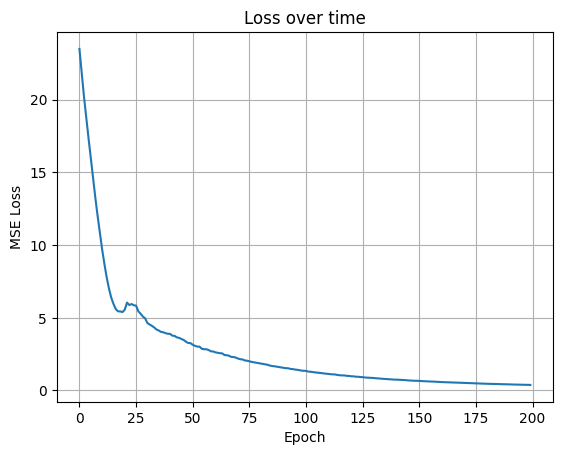

Test Loss: 0.3412, Precision: 0.3326, Recall: 0.2552, F1 Score: 0.2191


/home/seankhatiri/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)
        self.prediction_layer = torch.nn.Linear(6, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        src_embed = x[edge_index[0]]
        tgt_embed = x[edge_index[1]]
        edge_embeddings = torch.cat([src_embed, tgt_embed, edge_attr], dim=1)
        out = self.prediction_layer(edge_embeddings)
        return out.view(-1)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_values = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss over time')
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(data)
    loss = F.mse_loss(predictions, data.y)

    # Rounding the predictions and targets to convert continuous values into discrete values.
    rounded_preds = torch.round(predictions).int().cpu().numpy()
    rounded_targets = data.y.int().cpu().numpy()

    precision = precision_score(rounded_targets, rounded_preds, average='macro')
    recall = recall_score(rounded_targets, rounded_preds, average='macro')
    f1 = f1_score(rounded_targets, rounded_preds, average='macro')
    print(f"Test Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")